In [22]:
from __future__ import print_function, division
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import data as dt
import model as md
import copy
from pytorch_ssim import ssim
from torch.utils.data import DataLoader

In [ ]:
# print gpu
# print("Current GPU: " + str(torch.cuda.current_device()))
# print(str(torch.cuda.device_count()))

In [2]:
USE_GPU = 1
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:1')
else:
    device = "cpu"
print(device)

cpu


In [6]:
# generate csv file, run only for the first time
dt.generate_csv()

In [3]:
csvFilePath = dt.get_csv_path()
transformed_dataset = dt.HE_SHG_Dataset(csv_file=csvFilePath,
                                               transform=dt.Compose([
                                               dt.ToTensor(),
                                               dt.Rescale(96),
                                               dt.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])                                               
                                           ]))
# TODO: change the normalization parameters

In [4]:
dataloader = DataLoader(transformed_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

0 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
1 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
2 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
3 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


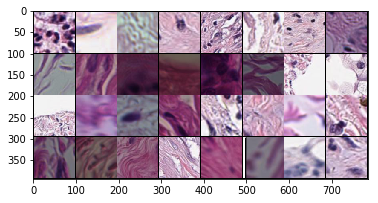

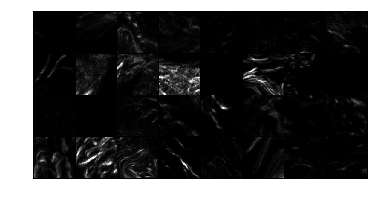

In [5]:
# TODO: insert back mean and variance to plot the image appropriately
dt.show_patch(dataloader) 

In [36]:
print('===> Building model')
model = md.Net().to(device)
criterionMSE = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)



===> Building model


In [37]:
def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(dataloader):
        input, target = batch['input'].to(device), batch['output'].to(device)

        optimizer.zero_grad()
        output = model(input)
        targetf = target.float()
        targetf = targetf[:, None]
        
        lossMSE = criterionMSE(output, targetf)      
        lossSSIM = -ssim(output, targetf)
        
        p = 0.25
        loss = p*lossMSE + (1-p)*lossSSIM
        combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
        
        epoch_loss = epoch_loss + combineLoss
        loss.backward()
        optimizer.step()
    
        if iteration%2 == 0:
            print("lossMSE: " + str(p*lossMSE.item()) +
                  " " + "lossSSIM: " + str((1-p)*lossSSIM.item()))
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(dataloader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(dataloader)))


In [ ]:
# def test():
#     avg_psnr = 0
#     with torch.no_grad():
#         for batch in testing_data_loader:
#             input, target = batch[0].to(device), batch[1].to(device)

#             prediction = model(input)
#             mse = criterion(prediction, target)
#             psnr = 10 * log10(1 / mse.item())
#             avg_psnr += psnr
#     print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))


In [ ]:
# def checkpoint(epoch):
#     model_out_path = "model_epoch_{}.pth".format(epoch)
#     torch.save(model, model_out_path)
#     print("Checkpoint saved to {}".format(model_out_path))

In [38]:
for epoch in range(1, 5 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)

lossMSE: 0.5625299215316772 lossSSIM: 0.06243002973496914
===> Epoch[1](0/25343): Loss: 0.6250
lossMSE: 0.5580747127532959 lossSSIM: 0.043613724410533905
===> Epoch[1](2/25343): Loss: 0.6017
lossMSE: 0.5647187232971191 lossSSIM: 0.039726206101477146
===> Epoch[1](4/25343): Loss: 0.6044
lossMSE: 0.5751346349716187 lossSSIM: 0.03793621156364679
===> Epoch[1](6/25343): Loss: 0.6131


KeyboardInterrupt: 